# Segmentação Automática de Vasos Retinianos em Imagens	de	Fundo de Olho (DRIVE) usando um detetor de linhas

In [1]:
##FUNÇÕES + IMPORTS

%pylab inline

import scipy.fftpack as pack
import numpy as np
import math
from PIL import Image, ImageOps
from timeit import default_timer as timer
from sklearn.datasets import fetch_mldata
from sklearn.svm import SVC
from sklearn.utils import shuffle
from sklearn import preprocessing
from time import time as tick
import scipy.misc
import scipy.ndimage
import sys

def getPontosLinha(pt0,pt1, linepts):
    #retorna os pontos da linha pt0 - pt1
    if pt0[1] < pt1[1]:
        x0 = int(pt0[1])
        y0 = int(pt0[0])
        x1 = int(pt1[1])
        y1 = int(pt1[0])
    else:
        x0 = int(pt1[1])
        y0 = int(pt1[0])
        x1 = int(pt0[1]) 
        y1 = int(pt0[0])

    dx = x1 - x0;   dy = y1 - y0;
    ind = 0;
    #print(dx)
    #print(dy)
    #linepts = zeros((sizeJanela,2)) #vrf
    #print(dx+dy)
    step = 1;
    if dx == 0:
        x = x0
        if dy < 0:
            step = -1
        for y in range(y0,y1+1,step):
            linepts[ind,:] = [y,x]
            ind = ind + 1;
    else:
        if abs(dy) > abs(dx):
            v=1
            if dy < 0:
                step = -1
                v=-1
            for y in range (y0,y1+v,step):
                x = round((dx/dy)*(y - y0) + x0)
                linepts[ind,:] = [y,x]
                ind = ind + 1
        else:
            for x in range(x0,x1+1):
                y = round((dy/dx)*(x - x0) + y0);
                linepts[ind,:] = [y,x]
                #print(ind)
                ind = ind + 1;
    #for i in range (ind, linepts.shape[0]):
    #    linepts[i,:] = [-1,-1]
    return linepts
    
def setLinha(theta, sizeJanela, linepts):
    halfsize = ceil((sizeJanela-1)/2)
    #print(halfsize)
    if theta == 0:
        #mask[int(halfsize),:] = 255
        ind=0
        for x in range(0,sizeJanela):
            linepts[ind,:] = [halfsize,x]
            ind+=1
    else:
        if theta == 90:
            #mask[:,int(halfsize)] = 255
            ind=0
            for y in range(0,sizeJanela):
                linepts[ind,:] = [y,halfsize]
                ind+=1
        else:
            x0 = -halfsize
            y0 = round(x0*(math.sin(math.radians(theta))/math.cos(math.radians(theta))))
            
            if y0 < -halfsize:
                y0 = -halfsize
                x0 = round(y0*(math.cos(math.radians(theta))/math.sin(math.radians(theta))))
            
            x1 = halfsize
            y1 = round(x1*(math.sin(math.radians(theta))/math.cos(math.radians(theta))))

            if y1 > halfsize:
                y1 = halfsize
                x1 = round(y1*(math.cos(math.radians(theta))/math.sin(math.radians(theta))))
            
            
            #print(sizeJanela)
            pt0y = halfsize-y0
            pt0x = halfsize+x0
            pt1y = halfsize-y1
            pt1x = halfsize+x1
            #quando o halfsize não pode ser no meio (sizeJanela é Par)
            if pt0y== sizeJanela:
                pt0y = pt0y - 1
            if pt0x == sizeJanela:
                pt0x = pt0x -1
            if pt1y == sizeJanela:
                pt1y = pt1y - 1
            if pt1x == sizeJanela:
                pt1x = pt1x -1
                
            #pt0 = [halfsize-y0, halfsize+x0]
            #pt1 = [halfsize-y1, halfsize+x1]
            
            pt0 = [pt0y, pt0x]
            pt1 = [pt1y, pt1x]
            
            #print(pt0)
            #print(pt1)
            getPontosLinha(pt0, pt1, linepts)
        return linepts
            #desenharLinha(pt0,pt1,mask)
    
    
def getReta(angulo,sizeJanela):
    linepts = zeros((sizeJanela,2))
    if angulo > 90:
        setLinha(180 - angulo,sizeJanela, linepts) #180-angulo porque a função foi desenhada para angulos 0 a 90 
        for i in range(0,sizeJanela): #rodar porque o angulo foi alterado 180o
            linepts[i,1] = sizeJanela-1-int(linepts[i,1]  )
    else:
        setLinha(angulo,sizeJanela, linepts)
    return linepts

    
def getRetas(retas,retasOrtog,sizeJanela, sizeOrtogonais):    
    for angulo in range (0,180,15):
        retas[:,:,int(angulo/15)] = getReta(angulo,sizeJanela)
        if angulo > 90:
            OrtoAngulo = angulo - 90 
        else:
            OrtoAngulo = angulo + 90 
        retasOrtog[:,:,int(angulo/15)] = getReta(OrtoAngulo,sizeOrtogonais)
        for i in range(0, sizeOrtogonais): #por pontos na janela 15 por 15
            retasOrtog[i,0,int(angulo/15)] += 6
            retasOrtog[i,1,int(angulo/15)] += 6
    
def processPixel(imgJanela,mask, retas, retasOrtog):
    
    sizeJanela = imgJanela.shape[0]
    halfSize = int ((sizeJanela-1)/2) 

                #Calcular media dos valores dentro da mascara --> N
    soma=0
    count=0
    for i in range (0, sizeJanela): 
        for j in range (0, sizeJanela):
            if (mask[i,j] > 0):
                soma += imgJanela[i,j]
                count += 1
    N=soma/count 
    
                #os valores fora da mask ficam iguais à media dos outros pixeis
    for i in range (0, sizeJanela): 
        for j in range (0, sizeJanela):
            if (mask[i,j] == 0):
                imgJanela[i,j] = N   
                
    L=0
    LOrto=0
    for reta in range (0, retas.shape[2]):  
        #Calcular media dos valores de cada Linha --> L
        sumLine=0
        count=0
        for i in range (0, sizeJanela): 
            sumLine += imgJanela[int(retas[i,0,reta]),int(retas[i,1,reta])]
            count += 1
        meanLine = sumLine/count
        if meanLine > L:
            L = meanLine
            bestReta=reta
    S=L-N 
    
    #Calcular media dos valores de cada Linha Ortogonal--> L para S0
    sumLine=0
    for i in range (0,3): 
        sumLine += imgJanela[int(retasOrtog[i,0,bestReta]),int(retasOrtog[i,1,bestReta])]
    LOrto = sumLine/3
    
    S0=LOrto-N     
       
    
    vector=zeros((3))
    vector[0]=S 
    vector[1]=S0
    vector[2]=imgJanela[halfSize,halfSize] #I - valor do proprio pixel
    return vector

Populating the interactive namespace from numpy and matplotlib


In [2]:
#LER IMAGENS (TRAINING)
print('a ler imagens de treino e teste...')
start = timer()
borda=15
DriveImgTreino=20
driveTrainingImg  = zeros((584+borda*2, 565+borda*2,DriveImgTreino))
driveTrainingMask = zeros((584+borda*2, 565+borda*2,DriveImgTreino))
outputTrain       = zeros((584, 565,DriveImgTreino)) 

for i in range(21,41):
    tempImg               = imread('DRIVE/training/images/' + str(i) + '_training.tif')[:, :, 1] #canal verde
    tempMask              = imread('DRIVE/training/mask/' + str(i) + '_training_mask.gif')
    outputTrain[:,:,i-21] = imread('DRIVE/training/1st_manual/' + str(i) + '_manual1.gif')
    #imgi.setflags(write=1) # to read-only error
    
    for y in range(0,outputTrain.shape[0]): #passar 255 para 1 porque é uma imagem
        for x in range(0,outputTrain.shape[1]):
            if (outputTrain[y,x,i-21] == 255):
                outputTrain[y,x,i-21] = 1
            
    #criar bordas para nunca se passar limites - os pixeis da borda não serão processados
    for y in range(borda,driveTrainingImg.shape[0]-borda):             
        for x in range(borda,driveTrainingImg.shape[1]-borda):        
            driveTrainingImg[y,x,i-21]  = 255-tempImg[y-borda,x-borda] #também inverte
            driveTrainingMask[y,x,i-21] = tempMask[y-borda,x-borda]
    #imsave('testleitura/img'+str(i)+'.tif',driveTrainingImg[:,:,i-21])
    #imsave('testleitura/mask'+str(i)+'.tif',driveTrainingMask[:,:,i-21])

    

# LER IMAGENS (TEST)
borda=15
DriveImgTest=20
driveTestImg =  zeros((584+borda*2, 565+borda*2,DriveImgTest))
driveTestMask = zeros((584+borda*2, 565+borda*2,DriveImgTest))
outputTest=             zeros((584, 565,DriveImgTest)) 

for i in range(1,21):
    if i<10:   #acrescentar 0
        tempImg               = imread('DRIVE/test/images/0' + str(i) + '_test.tif')[:, :, 1] #canal verde
        tempMask              = imread('DRIVE/test/mask/0' + str(i) + '_test_mask.gif')
        outputTest[:,:,i-21]  = imread('DRIVE/test/1st_manual/0' + str(i) + '_manual1.gif')
    else:
        tempImg               = imread('DRIVE/test/images/' + str(i) + '_test.tif')[:, :, 1] #canal verde
        tempMask              = imread('DRIVE/test/mask/' + str(i) + '_test_mask.gif')
        outputTest[:,:,i-21]  = imread('DRIVE/test/1st_manual/' + str(i) + '_manual1.gif')
        #imgi.setflags(write=1) # to read-only error

    for y in range(0,outputTrain.shape[0]): #passar 255 para 1 porque é uma imagem
        for x in range(0,outputTrain.shape[1]):
            if (outputTest[y,x,i-21] == 255):
                outputTest[y,x,i-21] = 1    
        
    #criar bordas para nunca se passar limites - os pixeis da borda não serão processados
    for y in range(borda,driveTrainingImg.shape[0]-borda):             
        for x in range(borda,driveTrainingImg.shape[1]-borda):        
            driveTestImg[y,x,i-21] = 255-tempImg[y-borda,x-borda] #também inverte
            driveTestMask[y,x,i-21] = tempMask[y-borda,x-borda]
    #imsave('testleitura/img'+str(i)+'.tif',driveTrainingImg[:,:,i-21])
    #imsave('testleitura/mask'+str(i)+'.tif',driveTrainingMask[:,:,i-21])
end = timer()
print('segundos: ' + str(end - start)) 
print('Leitura Completa')

a ler imagens de treino e teste...
segundos: 44.01803522725523
Leitura Completa


In [3]:
#Calcular pixeis das retas - funções acima
start = timer()
sizeJanela=15
sizeOrtogonais=3
retas      = zeros((sizeJanela, 2, 12))  #pontos das 12 retas com angulos 0 15 30 45 60 75 90 105 120 135 150 165
retasOrtog = zeros((sizeOrtogonais, 2, 12)) #pontos das 12 retas normais com angulos 0 15 30 45 60 75 90 105 120 135 150 165
getRetas(retas, retasOrtog, sizeJanela, sizeOrtogonais)
end = timer()
print('segundos: ' + str(end - start)) 
print('Retas Calculadas')

#para verificar se ver se as linhas estão corretas <----
#desenharRetas      = zeros((15, 15, 12)) #12 retas em 12 imagens 15x15 para visualização
#for r in range(0,12): 
#    for i in range(0,3):
#        desenharRetas[int(retasOrtog[i,0,r]), int(retasOrtog[i,1,r]),r]=255
#    for i in range(0,15):
#        desenharRetas[int(retas[i,0,r]), int(retas[i,1,r]),r]=255
#    imsave('Output/Retas/angulo'+str(r*15)+'.tif', desenharRetas[:,:,r])

segundos: 0.001127028997615298
Retas Calculadas


In [ ]:
print('A começar processamento de imagens de treino...')
start = timer()
#cada imagem demora 74 segundos em media, este tempo pode ser reduzido utilizando paralelismo, uma vez que o calculo
#de um pixel é independente do calculo dos outros pixeis
imgi = zeros((driveTrainingImg.shape[0], driveTrainingImg.shape[1]))
mask = zeros((driveTrainingImg.shape[0], driveTrainingImg.shape[1]))
vectToTrain = zeros((driveTrainingImg.shape[0]-borda*2, driveTrainingImg.shape[1]-borda*2, DriveImgTreino, 3))
for i in range(0,20): 
    imgi=driveTrainingImg[:,:,i]
    mask=driveTrainingImg[:,:,i]
    for y in range(borda,imgi.shape[0]-borda):   
        for x in range(borda, imgi.shape[1]-borda):   
            if mask[y,x] > 0:
                vectToTrain[y-borda,x-borda,i,:] = processPixel(imgi[ y-int((sizeJanela-1)/2) : y+int((sizeJanela-1)/2)+1 , x-int((sizeJanela-1)/2) : x+int((sizeJanela-1)/2)+1], mask[ y-int((sizeJanela-1)/2) : y+int((sizeJanela-1)/2)+1 , x-int((sizeJanela-1)/2) : x+int((sizeJanela-1)/2)+1], retas , retasOrtog)
    imsave('trainImagesS/S'+str(i)+'.tif', vectToTrain[:,:,i,0])    
    print('imagem '+str(i+1)+' completa')

end = timer()
print('segundos: ' + str(end - start)) 
print('Processamento completo')

In [9]:
print('A começar processamento de imagens de teste...')
start = timer()
#cada imagem demora 74 segundos em media, este tempo pode ser reduzido utilizando paralelismo, uma vez que o calculo
#de um pixel é independente do calculo dos outros pixeis
imgi = zeros((driveTestImg.shape[0], driveTestImg.shape[1]))
mask = zeros((driveTestImg.shape[0], driveTestImg.shape[1]))
vectToTest = zeros((driveTestImg.shape[0]-borda*2, driveTestImg.shape[1]-borda*2, DriveImgTest, 3))
for i in range(0,20): 
    imgi=driveTestImg[:,:,i]
    mask=driveTestImg[:,:,i]
    for y in range(borda,imgi.shape[0]-borda):   
        for x in range(borda, imgi.shape[1]-borda):   
            if mask[y,x] > 0:
                vectToTest[y-borda,x-borda,i,:] = processPixel(imgi[ y-int((sizeJanela-1)/2) : y+int((sizeJanela-1)/2)+1 , x-int((sizeJanela-1)/2) : x+int((sizeJanela-1)/2)+1], mask[ y-int((sizeJanela-1)/2) : y+int((sizeJanela-1)/2)+1 , x-int((sizeJanela-1)/2) : x+int((sizeJanela-1)/2)+1], retas , retasOrtog)
    imsave('testImagesS/S'+str(i)+'.tif', vectToTest[:,:,i,0])    
    print('imagem '+str(i+1)+' completa')

end = timer()
print('segundos: ' + str(end - start)) 
print('Processamento completo')

A começar processamento de imagens de teste...
imagem 1 completa
imagem 2 completa
imagem 3 completa
imagem 4 completa
imagem 5 completa
imagem 6 completa
imagem 7 completa
imagem 8 completa
imagem 9 completa
imagem 10 completa
imagem 11 completa
imagem 12 completa
imagem 13 completa
imagem 14 completa
imagem 15 completa
imagem 16 completa
imagem 17 completa
imagem 18 completa
imagem 19 completa
imagem 20 completa
segundos: 2332.1927910409286
Processamento completo


In [10]:
#aleatoriedade controlada - introduzir variabilidade
start = timer()
#vamos dividir cada imagem em 1000 subvetores (960 subvetores de 330 pixeis + 40 subvetores de 329 pixeis)
##em cada um destes subvetores vamos escolher um pixel, desta forma:
#vamos dividir cada um dos subvetores de 330/329 pixeis em 20subvetores (uma vez que temos 20 imagens) 
#SE subvetor = 330 
    #ficam 10 janelas de 17 pixeis + 10 janelas de 16 pixeis
#SE subvetor = 329
    #ficam 9 janelas de 17 pixeis + 11 janelas de 16 pixeis
#na imagem 1 escolhemos 1 pixel random da 1a janela de cada subvetor
#na imagem 2 escolhemos 1 pixel random da 2a janela de cada subvetor (etc)
#na imagem 20 escolhemos 1 pixel random da 20a janela de cada subvetor 

#dados de treino
#.ravel passa para uma dimensão - essencial para o treino com svm
X_temp = array([vectToTrain[:,:,:,0].ravel(), vectToTrain[:,:,:,1].ravel(), vectToTrain[:,:,:,2].ravel()])
X_temp = transpose(X_temp)
y_temp = outputTrain.ravel()

#print(X_train.shape[0]/20) #pixeis por imagem = 329960

amostraX = zeros((1000 * DriveImgTreino, 3))
amostraY = zeros((1000 * DriveImgTreino))

nmrPixel=0
indexPixel=0
for numImagem in range(0,20):
    nmrPixel=numImagem*329960 #pixel inicial #(nmrPixeis numa imagem = 329960)   
    indexEscolhido=0
    for subvetor in range(0,1000):
        if subvetor < 960:
            tamanhoVetor=330
            if numImagem < 10: #10 janelas de 16
                tamanhoJanela=16
                localJanela=16*numImagem
            else: #10 janelas de 17
                tamanhoJanela=17
                localJanela=16*10+17*(numImagem-10)
        else: #40 subvetores de 329 pixeis
            tamanhoVetor=329
            if numImagem < 11: #11 janelas de 16
                tamanhoJanela=16
                localJanela=16*numImagem
            else: #9 janelas de 17
                tamanhoJanela=17
                localJanela=16*11+17*(numImagem-11)
        indexEscolhido = nmrPixel + localJanela + randint(0,tamanhoJanela)
        amostraX[indexPixel,:] = X_temp[indexEscolhido,:]
        amostraY[indexPixel] = y_temp[indexEscolhido]
        nmrPixel+= tamanhoVetor 
        indexPixel+=1
end = timer()
print('segundos: ' + str(end - start)) 
print('Amostras selecionadas adequeadamente')

segundos: 0.6284400537024339
Amostras selecionadas adequeadamente


In [4]:
#np.save('vectToTrain', vectToTrain)
#np.save('vectToTest', vectToTest)
#np.save('X_train', X_train)
##fim do programa
#np.save('X_test', X_test)
#np.save('y_test', y_test)
#np.save('y_train', y_train)
#np.save('clf', clf)


#caso seja necessário

vectToTrain = np.load('vectToTrain.npy')
vectToTest = np.load('vectToTest.npy')
X_train = np.load('X_train.npy')
X_test = np.load('X_test.npy' )
y_test = np.load('y_test.npy' )
y_train = np.load('y_train.npy' )
clf = np.load('clf.npy')
amostraX = np.load('X_train.npy')
amostraY = np.load('y_train.npy')
y_train=np.asarray(y_train, dtype=int)
y_test=np.asarray(y_test, dtype=int)

In [ ]:
X_train = amostraX
y_train = amostraY
print('dimensão de dados de entrada (treino) = ' + str(X_train.shape))
print('dimensão de dados de saida (treino) = ' + str(y_train.shape))
random_state = np.random.RandomState(0)
X_train, y_train = shuffle(X_train, y_train, random_state=random_state) #introduzir variabilidade

#dados de teste
X_test = array([vectToTest[:,:,:,0].ravel(), vectToTest[:,:,:,1].ravel(), vectToTest[:,:,:,2].ravel()])
X_test = transpose(X_test)
y_test = outputTest.ravel()
print('dimensão de dados de entrada (teste) = ' + str(X_test.shape))
print('dimensão de dados de saida (teste)= ' + str(y_test.shape))
random_state = np.random.RandomState(0)

#X_test, y_test = shuffle(X_test, y_test, random_state=random_state) teste não precisa de shuffle


scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

#treino com svm
clf = SVC(kernel='linear')
tin = tick()
print('Treino com svm...')
clf = clf.fit(X_train, y_train)
tout = tick()

print("Taxa de sucesso (Treino): ",
      np.mean(clf.predict(X_train) == y_train) * 100)

data = clf.predict(X_test)
print("Taxa de sucesso (Teste): ",
      np.mean(data == y_test) * 100)

print("Número de vectors de dados (treino/teste): {} / {}".
      format(X_train.shape[0], X_test.shape[0]))
print("Número de vectores de suport: ", clf.support_vectors_.shape[0])
print('Training time: {:.3f} s'.format(tout - tin))


imnum=1
for i in range(0,data.shape[0],329960):  #guardar as imagens
    img = data[i:i+329960].reshape((584,565))
    imsave('DRIVE/test/ResultadosSVM/' + str(imnum)+'_testSVM.tif',img)
    imnum+=1

##fim do programa

dimensão de dados de entrada (treino) = (20000, 3)
dimensão de dados de saida (treino) = (20000,)
dimensão de dados de entrada (teste) = (6599200, 3)
dimensão de dados de saida (teste)= (6599200,)
Treino com svm...
Taxa de sucesso (Treino):  91.585


# PARA UMA IMAGEM:

In [74]:
##PARA UMA IMAGEM:
#------------------------------
start = timer()
#driveTrainingImg = zeros((imGreen.shape[0]+borda*2, imGreen.shape[1]+borda*2))
#driveTrainingMask = []
#for i in range(21,41):
#    driveTrainingImg.append(imread('DRIVE/training/images/' + str(i) + '_training.tif'))
#    driveTrainingMask.append(imread('DRIVE/training/mask/' + str(i) + '_training_mask.gif'))
    
MaskOrig=imread('DRIVE/training/mask/21_training_mask.gif')
Orig=imread('DRIVE/training/images/21_training.tif')
imGreen=Orig[:, :, 1] 

borda=15
mask = zeros((imGreen.shape[0]+borda*2, imGreen.shape[1]+borda*2))
imgi = zeros((imGreen.shape[0]+borda*2, imGreen.shape[1]+borda*2))

    #imgi.setflags(write=1) # to read-only error

    #criar bordas para nunca se passar limites
for y in range(borda,imgi.shape[0]-borda):             
    for x in range(borda,imgi.shape[1]-borda):        
        mask[y,x] = MaskOrig[y-borda,x-borda] #,1
        imgi[y,x] = imGreen[y-borda,x-borda]     

    #imgsubmask = imgi.copy()                      #para verificar mascara
    #for y in range(0,imgi.shape[0]):             
    #    for x in range(0,imgi.shape[1]):        
    #        if mask[y,x]>0:
    #            imgsubmask[y,x] = 0     
    #imsave('verMaskSub.tif', imgsubmask) 

for i in range(0,imgi.shape[0]):        #inversão     
    for j in range(0,imgi.shape[1]):        
        imgi[i,j]=255-imgi[i,j]

sizeJanela=15
sizeOrtogonais=3
retas      = zeros((sizeJanela, 2, 12))  #pontos das 12 retas com angulos 0 15 30 45 60 75 90 105 120 135 150 165
retasOrtog = zeros((sizeOrtogonais, 2, 12)) #pontos das 12 retas normais com angulos 0 15 30 45 60 75 90 105 120 135 150 165
getRetas(retas, retasOrtog, sizeJanela, sizeOrtogonais)

#para verificar se ver se as linhas estão corretas
#desenharRetas      = zeros((15, 15, 12)) #12 retas em 12 imagens 15x15 para visualização
#for r in range(0,12): 
#    for i in range(0,3):
#        desenharRetas[int(retasOrtog[i,0,r]), int(retasOrtog[i,1,r]),r]=255
#    for i in range(0,15):
#        desenharRetas[int(retas[i,0,r]), int(retas[i,1,r]),r]=255
#    imsave('Output/Retas/angulo'+str(r*15)+'.tif', desenharRetas[:,:,r])

vectToTrainS = zeros((imgi.shape[0]-borda*2, imgi.shape[1]-borda*2, 3))
ind=0
for i in range(1,2): 
    #imgi=driveTrainingImg[i]
    #mask=driveTrainingImg[i]
    for y in range(borda-1,imgi.shape[0]-borda):   
        print(str(y-(borda-1)))
        for x in range(borda-1, imgi.shape[1]-borda):   
            if mask[y,x] > 0:
                vectToTrainS[y-(borda-1),x-(borda-1),:] = processPixel(imgi[ y-int((sizeJanela-1)/2) : y+int((sizeJanela-1)/2)+1 , x-int((sizeJanela-1)/2) : x+int((sizeJanela-1)/2)+1], mask[ y-int((sizeJanela-1)/2) : y+int((sizeJanela-1)/2)+1 , x-int((sizeJanela-1)/2) : x+int((sizeJanela-1)/2)+1], retas , retasOrtog)
        
#for x in range (15,imGreen.shape[0]-15):
#    for y in range (15,imGreen.shape[1]-15):
#        processPixel(imgi,x,y)


end = timer()
print(end - start) 

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

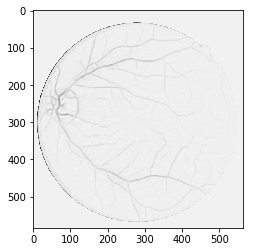

In [75]:
seg = zeros((imgi.shape[0]-borda*2, imgi.shape[1]-borda*2))
for y in range(0,vectToTrainS.shape[0]):   
    for x in range(0, vectToTrainS.shape[1]):   
        if vectToTrainS[y,x,0] > 2:
            seg[y,x]=1
        else:
            seg[y,x]=0
imshow(255-vectToTrainS[:,:,0],cmap='gray')

#scipy.misc.toimage(vectToTrainS[:,:,0], cmin=0.0, cmax=0).save('S.tif')
imsave('S.tif', 255-vectToTrainS[:,:,0])

In [20]:

#treino com svm
clf = SVC(kernel='linear')
tin = tick()
print('Treino com svm...')
X_train = array([[ 0,  0,  0],
       [ 1,  1, 1,]])
X_test = array([[ 0,  0,  0],
       [ 1,  1, 1,]])
y_train=array([ 0,  1])
y_test=array([ 0,  1])
clf = clf.fit(X_train, y_train)
tout = tick()

print("Taxa de sucesso (Treino): ",
      np.mean(clf.predict(X_train) == y_train) * 100)

data = clf.predict(X_test)
print("Taxa de sucesso (Teste): ",
      np.mean(data == y_test) * 100)

print("Número de vectors de dados (treino/teste): {} / {}".
      format(X_train.shape[0], X_test.shape[0]))
print("Número de vectores de suport: ", clf.support_vectors_.shape[0])
print('Training time: {:.3f} s'.format(tout - tin))


imnum=1
for i in range(0,data.shape[0],329960):  #guardar as imagens
    img = data[i:i+329960].reshape((584,565))
    imsave('DRIVE/test/ResultadosSVM/' + str(imnum)+'_testSVM.tif',img)
    imnum+=1

Treino com svm...
Taxa de sucesso (Treino):  100.0
Taxa de sucesso (Teste):  100.0
Número de vectors de dados (treino/teste): 2 / 2
Número de vectores de suport:  2
Training time: 0.001 s


ValueError: cannot reshape array of size 2 into shape (584,565)